<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter3/src/test_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 構築した機械学習モデルを運用

## Google Colabの準備

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabの左端のファイル（ファイルのアイコン）をクリックし、chapter3_demo_data_postprocess.csv、chapter3_demo_data_postprocess_test.csvをドラッグ＆ドロップしてアップロード
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

## ライブラリをインポート

### 必要に応じてpip installを実行（Google Colabで実行の場合は必須）

In [3]:
! pip install scikit-learn==1.3.2 #ライブラリのverによっては次元圧縮の挙動が異なることがあるため注意
! pip install numpy==1.26.4
! pip install pandas==2.2.2
! pip install japanize_matplotlib==1.1.3
! pip install adjustText==1.2.0
! pip install umap-learn==0.5.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 33.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=c46f3dde6cfe7b4e1cb7b33bb68fffd85415a12f7ede3766b7294b78346266c0
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize_matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.1 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86834 sha256=a74205292

In [4]:
import os
import warnings

warnings.filterwarnings("ignore")

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from adjustText import adjust_text
from pandas import json_normalize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

## グラフ表示の際のフォント種類やフォントサイズを設定

In [5]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["font.family"] = "IPAexGothic"

## ファイルのコンフィグ情報を定義

In [6]:
class CFG:
    input_dir = INPUT_FILE_PATH
    output_dir = OUTPUT_FILE_PATH
    random_seed = 42
    exp_no = "test_analysis"

## データを読み込み、データフレームに格納

In [7]:
train_df = pd.read_csv(f"{CFG.input_dir}/chapter3_demo_data_postprocess.csv")
train_df

,サンプルID,サンプル作製日,担当者,備考,材料１,材料２,材料３,材料４,材料５,材料６,...,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性,画像濃度,粘度,表面張力,保存後粘度,保存後状態
0,DP_001,2024/1/19,高岡,NaN,46.9,40,0,2,0,2.0,...,25,NaN,10,5,2.4,1.06,9.0,35,NaN,NaN
1,DP_002,2024/1/19,高岡,NaN,47.4,40,0,2,0,1.5,...,25,NaN,10,5,2.4,1.07,9.0,38,NaN,NaN
2,DP_003,2024/1/19,高岡,NaN,47.7,40,0,2,0,1.2,...,25,NaN,10,5,2.4,1.07,9.0,40,NaN,NaN
3,DP_004,2024/1/19,高岡,NaN,47.9,40,0,2,0,1.0,...,25,NaN,10,5,2.4,1.08,9.0,41,NaN,NaN
4,DP_005,2024/1/19,高岡,NaN,48.4,40,0,2,0,0.5,...,25,NaN,10,5,2.4,1.09,9.0,44,NaN,NaN
5,DP_006,2024/1/30,福原,ref,47.4,40,0,2,0,1.5,...,25,NaN,10,5,2.7,1.07,9.1,38,NaN,NaN
6,DP_007,2024/1/30,福原,NaN,47.4,40,0,2,0,0.0,...,25,NaN,10,5,2.7,1.05,9.1,37,NaN,NaN
7,DP_008,2024/1/30,福原,NaN,47.4,40,0,2,0,0.0,...,25,NaN,10,5,2.7,1.02,9.1,39,NaN,NaN
8,DP_009,2024/1/30,福原,NaN,45.4,40,0,2,0,1.5,...,25,NaN,10,5,3.1,1.07,10.3,36,NaN,NaN
9,DP_010,2024/1/30,福原,NaN,43.4,40,0,2,0,1.5,...,25,NaN,10,5,3.6,1.07,11.5,34,NaN,NaN


## テストデータを読み込み、データフレームに格納

In [8]:
test_df = pd.read_csv(f"{CFG.input_dir}/chapter3_demo_data_postprocess_test.csv")
test_df

,サンプルID,サンプル作製日,担当者,備考,材料１,材料２,材料３,材料４,材料５,材料６,...,乾燥温度,乾燥時間,擦過回数,擦過圧力,耐擦過性,画像濃度,粘度,表面張力,保存後粘度,保存後状態
0,DP_test_01,NaN,NaN,NaN,38.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.64,10.3,32,76.7,ゲル化
1,DP_test_02,NaN,NaN,NaN,38.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.61,10.2,32,12.6,正常
2,DP_test_03,NaN,NaN,NaN,38.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.57,10.0,32,33.7,ゲル化
3,DP_test_04,NaN,NaN,NaN,40.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.46,9.2,34,11.6,正常
4,DP_test_05,NaN,NaN,NaN,40.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.43,9.1,34,11.5,正常
5,DP_test_06,NaN,NaN,NaN,40.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.41,9.0,34,11.4,正常
6,DP_test_07,NaN,NaN,NaN,42.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.25,8.1,35,10.5,正常
7,DP_test_08,NaN,NaN,NaN,42.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.24,8.1,35,10.5,正常
8,DP_test_09,NaN,NaN,NaN,42.4,0,40,0,2,1.5,...,100,0.03,10,5,5,1.22,8.0,35,10.4,正常


## 使用する説明変数をリストとして定義

In [9]:
numeric_parameter_cols = [
    # 'サンプルID',
    # 'サンプル名',
    # 'サンプル作成日',
    # '担当者',
    # '備考',
    "材料１",
    "材料２",
    "材料３",
    "材料４",
    "材料５",
    "材料６",
    "材料７",
    "材料８",
    "材料９",
    "材料１０",
    "材料１１",
    "材料１２",
    "材料１３",
    "塗布量",
    "乾燥方式",
    "乾燥温度",
    # '乾燥時間',
    "擦過回数",
    "擦過圧力",
    # '耐擦過性','画像濃度', '粘度', '表面張力', '保存後粘度'
]

## 説明変数のスケーリング

In [10]:
scaler_x = StandardScaler()
scaler_x.fit(train_df[numeric_parameter_cols])
scaler_x

StandardScaler()

In [11]:
X_train = scaler_x.transform(train_df[numeric_parameter_cols])
X_train

array([[ 1.00830673,  0.75592895, -0.75438695,  0.55339859, -0.68624357,
         1.53976945, -0.1767767 , -0.1767767 ,  0.12768848, -0.35355339,
        -0.86677605, -0.2943724 ,  0.        ,  0.        , -1.16496475,
        -1.15482139,  0.        ,  0.        ],
       [ 1.16797142,  0.75592895, -0.75438695,  0.55339859, -0.68624357,
         0.31831772, -0.1767767 , -0.1767767 ,  0.12768848, -0.35355339,
        -0.86677605, -0.2943724 ,  0.        ,  0.        , -1.16496475,
        -1.15482139,  0.        ,  0.        ],
       [ 1.26377024,  0.75592895, -0.75438695,  0.55339859, -0.68624357,
        -0.41455331, -0.1767767 , -0.1767767 ,  0.12768848, -0.35355339,
        -0.86677605, -0.2943724 ,  0.        ,  0.        , -1.16496475,
        -1.15482139,  0.        ,  0.        ],
       [ 1.32763612,  0.75592895, -0.75438695,  0.55339859, -0.68624357,
        -0.903134  , -0.1767767 , -0.1767767 ,  0.12768848, -0.35355339,
        -0.86677605, -0.2943724 ,  0.        ,  0.   

## UMAPで説明変数を2次元に圧縮し可視化（n_neighbors=5）&各水準のIDを表示

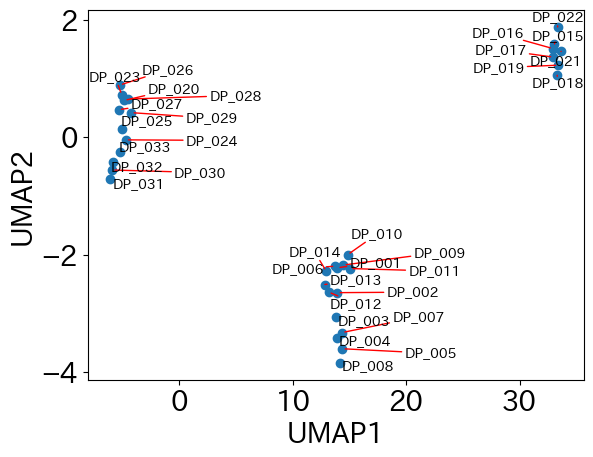

In [12]:
# UMAPを実行、n_components=2、random_state=CFG.random_seed
umap_ = umap.UMAP(
    n_components=2,
    random_state=CFG.random_seed,
    n_neighbors=5,
)  # n_neighborsのデフォルト値は15
X_train_umap = umap_.fit_transform(X_train)
X_train_umap

# X_train_umapをDataFrameに変換
train_umap_df = pd.DataFrame(X_train_umap, columns=["UMAP1", "UMAP2"])

# train_umap_dfの散布図を描画
plt.scatter(train_umap_df["UMAP1"], train_umap_df["UMAP2"])
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
# plt.txtで対応するサンプルIDを表示、adjustTextモジュールを使用して、重なりがないように表示
texts = [
    plt.text(
        train_umap_df["UMAP1"][i],
        train_umap_df["UMAP2"][i],
        train_df["サンプルID"][i],
        fontsize=10,
    )
    for i in range(len(train_umap_df))
]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="red"))
plt.show()

## テストデータの説明変数のスケーリング

In [13]:
X_test = scaler_x.transform(test_df[numeric_parameter_cols])
X_test

array([[-1.70599306, -1.32287566,  1.32017716, -1.18585412,  0.99124071,
         0.31831772, -0.1767767 , -0.1767767 , -1.55779945,  3.04055916,
         0.63867709, -0.2943724 ,  0.        ,  0.        ,  0.85839508,
         0.85092103,  0.        ,  0.        ],
       [-1.70599306, -1.32287566,  1.32017716, -1.18585412,  0.99124071,
         0.31831772, -0.1767767 , -0.1767767 ,  0.12768848,  1.76776695,
         0.63867709, -0.2943724 ,  0.        ,  0.        ,  0.85839508,
         0.85092103,  0.        ,  0.        ],
       [-1.70599306, -1.32287566,  1.32017716, -1.18585412,  0.99124071,
         0.31831772, -0.1767767 , -0.1767767 ,  1.81317641,  0.49497475,
         0.63867709, -0.2943724 ,  0.        ,  0.        ,  0.85839508,
         0.85092103,  0.        ,  0.        ],
       [-1.06733428, -1.32287566,  1.32017716, -1.18585412,  0.99124071,
         0.31831772, -0.1767767 , -0.1767767 , -1.55779945,  2.19203102,
         0.63867709, -0.2943724 ,  0.        ,  0.   

## UMAPの学習モデルを使用して、学習データとテストデータを同じ空間に描画

In [14]:
umap_ = umap.UMAP(
    n_components=2, random_state=CFG.random_seed, n_neighbors=5
)  # n_neighborsのデフォルト値は15

result_umap = umap_.fit(X_train)
result_umap

UMAP(n_neighbors=5, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [15]:
X_train_umap = result_umap.transform(X_train)
X_train_umap

array([[13.943232  , -2.2236116 ],
       [13.955266  , -2.646678  ],
       [13.812184  , -3.0674899 ],
       [13.927896  , -3.4114    ],
       [14.3908825 , -3.6014824 ],
       [13.77035   , -2.1960652 ],
       [14.36668   , -3.3256958 ],
       [14.1511965 , -3.8430026 ],
       [14.480962  , -2.176145  ],
       [14.852762  , -1.9999454 ],
       [15.078515  , -2.2359684 ],
       [13.169968  , -2.635323  ],
       [12.842902  , -2.5080621 ],
       [12.963939  , -2.2801163 ],
       [33.06941   ,  1.588461  ],
       [32.934086  ,  1.5086951 ],
       [32.975708  ,  1.3633107 ],
       [33.313282  ,  1.0532873 ],
       [33.41114   ,  1.2256603 ],
       [-4.8212147 ,  0.6260406 ],
       [33.65676   ,  1.4614683 ],
       [33.35256   ,  1.8772041 ],
       [-5.048616  ,  0.7213821 ],
       [-4.6957645 , -0.04543311],
       [-5.005794  ,  0.13114758],
       [-5.2212276 ,  0.88765055],
       [-5.3250775 ,  0.4683751 ],
       [-4.48743   ,  0.6491049 ],
       [-4.1977406 ,

In [16]:
X_test_umap = result_umap.transform(X_test)
X_test_umap

array([[-6.3167057 , -1.112277  ],
       [-6.033771  ,  0.50211036],
       [-3.7387023 ,  0.16686457],
       [-5.7768197 , -1.1405206 ],
       [-6.1272397 ,  0.29586375],
       [-4.8251324 ,  1.4034332 ],
       [-6.2790236 ,  0.08080379],
       [-4.9445    , -0.8306473 ],
       [-5.931433  ,  0.8601453 ]], dtype=float32)

In [17]:
train_umap_df = pd.DataFrame(X_train_umap, columns=["UMAP1", "UMAP2"])
test_umap_df = pd.DataFrame(X_test_umap, columns=["UMAP1", "UMAP2"])

In [18]:
train_umap_df

,UMAP1,UMAP2
0,13.943232,-2.223612
1,13.955266,-2.646678
2,13.812184,-3.067490
3,13.927896,-3.411400
4,14.390882,-3.601482
5,13.770350,-2.196065
6,14.366680,-3.325696
7,14.151196,-3.843003
8,14.480962,-2.176145
9,14.852762,-1.999945


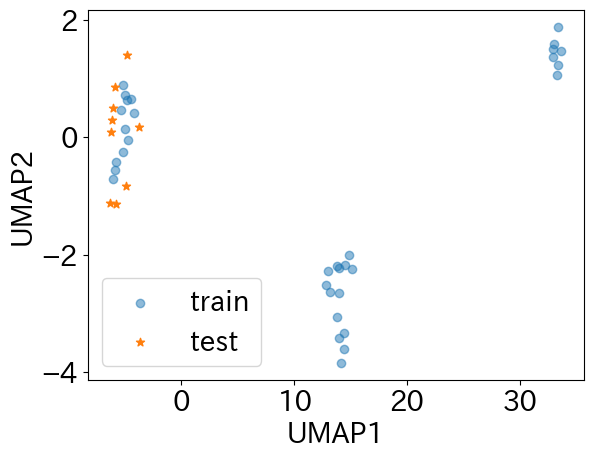

In [19]:
plt.scatter(train_umap_df["UMAP1"], train_umap_df["UMAP2"], alpha=0.5)
plt.scatter(test_umap_df["UMAP1"], test_umap_df["UMAP2"], marker="*")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(["train", "test"])
plt.show()

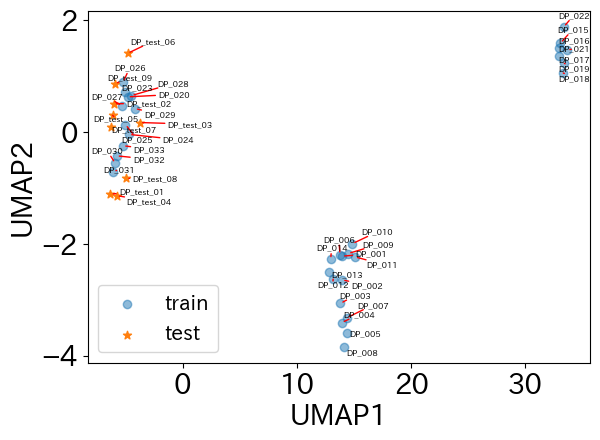

In [20]:
fig, ax = plt.subplots()
ax.scatter(train_umap_df["UMAP1"], train_umap_df["UMAP2"], label="train", alpha=0.5)
ax.scatter(test_umap_df["UMAP1"], test_umap_df["UMAP2"], label="test", marker="*")

# テキストのサイズを小さく設定
texts = [
    ax.text(x, y, s, fontsize=6)
    for x, y, s in zip(
        train_umap_df["UMAP1"].values,
        train_umap_df["UMAP2"].values,
        train_df["サンプルID"].values,
    )
]
texts += [
    ax.text(x, y, s, fontsize=6)
    for x, y, s in zip(
        test_umap_df["UMAP1"].values,
        test_umap_df["UMAP2"].values,
        test_df["サンプルID"].values,
    )
]

# adjust_textを使用してテキストが重ならないように調整
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="red"))

# 軸ラベルと凡例の設定
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

## 実行環境のライブラリverを保存

In [21]:
!pip freeze > test_data_analysis.txt

In [22]:
from google.colab import files

files.download('test_data_analysis.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>